<a href="https://colab.research.google.com/github/abhiWriteCode/Balanced-Cartpole/blob/master/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cartpole

Balance a pole in an upright position by only moving your base left or right. Low-dimensional observation space.


![alt text](https://www.kdnuggets.com/images/reinforcement-learning-fig1-700.jpg)

In [0]:
#@title Install dependencies
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install --upgrade tensorflow > /dev/null 2>&1
!pip install gym pyvirtualdisplay scikit-video > /dev/null 2>&1

In [4]:
import tensorflow as tf

import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
import time

import utils

tf.__version__

'2.0.0'

### Define the environment

In [5]:
env = gym.make("CartPole-v0")
env.seed(1) # reproducible, since RL has high variance

[1]


**CartPole Environment: ** 

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

<img width="400px" src="https://danielpiedrahita.files.wordpress.com/2017/02/cart-pole.png"></img>

Observations:

1. position of cart
2. velocity of cart
3. angle of pole
4. rotation rate of pole

The size of the space by querying the observation space:


In [6]:
print("Enviornment has observation space = {}".format(env.observation_space))

Enviornment has observation space = Box(4,)


The size of the action space by querying the environment:

In [7]:
n_actions = env.action_space.n
print("Number of possible actions that the agent can choose from = {}".format(n_actions))

Number of possible actions that the agent can choose from = 2


### Define the Agent

In [0]:
def create_cartpole_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(units=32, activation='relu'),

        # define the output dimension of the last Dense layer that the space the agent needs to act in
        tf.keras.layers.Dense(units=n_actions, activation=None)
    ])
    return model

cartpole_model = create_cartpole_model()

Define the action function that executes a forward pass through the network and samples from the output. Take special note of the output activation of the model.

In [0]:
def choose_action(model, observation):
    
    observation = observation.reshape([1, -1])
    # feed the observations through the model to predict the log probabilities of each possible action.
    logits = model.predict(observation) 

    # pass the log probabilities through a softmax to compute true probabilities
    prob_weights = tf.nn.softmax(logits).numpy()

    # randomly sample from the prob_weights to pick an action.
    # carefully consider the dimensionality of the input probabilities (vector) and the output action (scalar)
    action = np.random.choice(n_actions, size=1, p=prob_weights.flatten())[0]

    return action

### 1.3 Create the agent's memory

During training, the agent will need to remember all of its observations, actions so that once the episode ends, it can "reinforce" the good actions and punish the undesirable actions. Let's do this by defining a simple memory buffer that contains the agent's observations, actions, and received rewards from a given episode. 

In [0]:
from collections import deque

class Memory:
    def __init__(self, buffer_size=-1): 
        self.size = buffer_size
        self.clear()

    def clear(self):
        self.observations = deque() if self.size == -1 else deque(maxlen=buffer_size)
        self.actions = deque() if self.size == -1 else deque(maxlen=buffer_size)
        self.rewards = deque() if self.size == -1 else deque(maxlen=buffer_size)

    def add_to_memory(self, new_observation, new_action, new_reward): 
        self.observations.append(new_observation)

        # update the list of actions with new action
        self.actions.append(new_action) 

        # update the list of rewards with new reward
        self.rewards.append(new_reward) 

Almost ready to begin the learning algorithm for our agent! The final step is to compute the discounted rewards of our agent. Recall from lecture, we use reward discount to give more preference at getting rewards now rather than later in the future. The idea of discounting rewards is similar to discounting money in the case of interest and can be defined as: 

>$R_{t}=\sum_{k=0}^\infty\gamma^kr_{t+k}$

where  $\gamma$ is the discount factor. In other words, at the end of an episode, we'll want to depreciate any rewards received at later time steps. Since we can't play an infinite number of games, we'll be limited to the number of timesteps in an episode. When implementing the function, you can initialize a numpy array of zeros (with length of the number of time steps) and fill it with the real discounted reward values as you loop through the saved rewards from the episode. We'll also want to normalize our output, which you can do using information about the mean and standard deviation of the discounted rewards.


In [0]:
def normalize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x


def discount_rewards(rewards, gamma=0.9): 
    discounted_rewards = np.zeros_like(rewards)
    R = 0
    
    for t in reversed(range(0, len(rewards))):
        # update the total discounted reward
        R = R * gamma + rewards[t]
        discounted_rewards[t] = R

    return normalize(discounted_rewards)

### Define the learning algorithm

In [0]:
memory = Memory(buffer_size=-1)
learning_rate = 1e-2
optimizer = tf.keras.optimizers.Adam(learning_rate)

And now let's define the loss function. In this lab we are focusing on policy gradient methods which aim to **maximize** the likelihood of actions that result in large rewards. Equivalently, this means that we want to **minimize** the negative likelihood of these same actions. Like in supervised learning, we can use stochastic gradient descent methods to achieve this minimization. 

Since the log function is monotonically increasing, this means that minimizing negative **likelihood** is equivalent to minimizing negative **log-likelihood**.  Recall that we can easily compute the negative log-likelihood of an discrete action by evaluting its [softmax cross entropy](https://www.tensorflow.org/api_docs/python/tf/nn/sparse_softmax_cross_entropy_with_logits) 

In [0]:
def compute_loss(logits, actions, rewards): 
    
    # complete the call to compute the loss
    neg_logprob = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=actions) 

    # scale the negative log probability by the rewards
    loss = tf.reduce_mean( neg_logprob * rewards ) 
    return loss

In [0]:
def train_step(model, optimizer, observations, actions, discounted_rewards):
    with tf.GradientTape() as tape:

        # Forward propogate through the agent
        observations = tf.convert_to_tensor(observations, dtype=tf.float32)
        logits = model(observations)

        # call the compute_loss function to compute the loss
        loss = compute_loss(logits, actions, discounted_rewards) 

    # run backpropagation using the tape.gradient method
    grads = tape.gradient(loss, model.variables) 
    optimizer.apply_gradients(zip(grads, model.variables))

## Let the agent go and watch it learn from scratch!

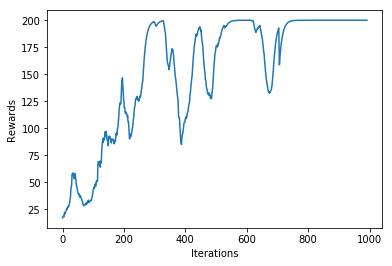

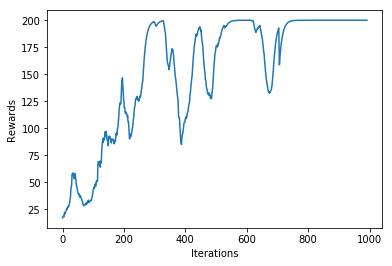

In [33]:
%%time

cartpole_model = create_cartpole_model()

smoothed_reward = utils.LossHistory(smoothing_factor=0.9)
plotter = utils.PeriodicPlotter(sec=10, xlabel='Iterations', ylabel='Rewards')


for i_episode in range(1000):

    plotter.plot(smoothed_reward.get())

    # Restart the environment
    observation = env.reset()

    while True:
        # using our observation, take an action
        action = choose_action(cartpole_model, observation)
        next_observation, reward, done, info = env.step(action)
        # add to memory
        memory.add_to_memory(observation, action, reward)

        # is the episode over? did you crash or do so well that you're done?
        if done:
            # determine total reward and keep a record of this
            total_reward = sum(memory.rewards)
            smoothed_reward.append( total_reward )

            # initiate training - remember we don't know anything about how the agent is doing until it's crashed!
            train_step(cartpole_model, optimizer, 
                       observations = np.vstack(memory.observations),
                       actions = np.array(memory.actions),
                       discounted_rewards = discount_rewards(memory.rewards, 
                                                             gamma=1)
                      )

            memory.clear()
            break
        # update our observatons
        observation = next_observation

### Save a video of the trained model while it is balancing the pole

In [0]:
def save_video_of_model(model, env_name, filename='agent.mp4'):  
    import skvideo.io
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(40, 30))
    display.start()

    env = gym.make(env_name)
    obs = env.reset()
    shape = env.render(mode='rgb_array').shape[0:2]

    out = skvideo.io.FFmpegWriter(filename)

    done = False
    while not done: 
        frame = env.render(mode='rgb_array')
        out.writeFrame(frame)

        action = model(tf.convert_to_tensor(obs.reshape((1,-1)), tf.float32)).numpy().argmax()
        obs, reward, done, info = env.step(action)
    out.close()
    print("Successfully saved into {}!".format(filename))

save_video_of_model(cartpole_model, "CartPole-v0")

Successfully saved into agent.mp4!


### Display the saved video

In [0]:
from IPython.display import HTML
import io, base64
video = io.open('./agent.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
<video controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
</video>'''.format(encoded.decode('ascii')))